In [1]:
import numpy as np
import scipy
import scipy.linalg
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Literal
import math
import polars as pl

# for R access to logspline
from rpy2.robjects.packages import importr
from rpy2.robjects import r, default_converter, vectors, numpy2ri
from rpy2.robjects.conversion import localconverter
from tqdm.notebook import tqdm

Error importing in API mode: ImportError("dlopen(/Users/alex.shtoff/git/intfeat/.venv/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <05EE76C0-33BF-3D4C-BC56-84005241BC88> /Users/alex.shtoff/git/intfeat/.venv/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


In [2]:
mpl.rcParams['figure.figsize'] = [4, 3]
mpl.rcParams['figure.dpi'] = 96 * 3

In [3]:
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
try:
    logspline = importr("logspline")
except Exception:
    utils.install_packages("logspline")
    logspline = importr("logspline")

In [4]:
hist_color = 'dimgray'
weights_color = 'orange'

laplacian_color = 'blue'
kde_color = 'firebrick'
logspline_color = 'forestgreen'

# Distributions

In [5]:
max_val = 5000
shaping_strength = 1
xs = np.arange(max_val)

In [6]:
def normalize(w):
    w = np.asarray(w, float)
    w = np.maximum(w, 0)
    s = w.sum()
    return w / s if s > 0 else np.full_like(w, 1.0 / len(w))


def weights_bimodal_powerlaw(alpha=5.0, beta=1.0):
    ws_1 = (alpha + np.abs(xs - max_val / 3)) ** (-beta)
    ws_2 = (alpha + np.abs(xs - 2 * max_val / 3)) ** (-beta)
    ws = (ws_1 + ws_2) / 2.0
    return normalize(ws)


def weights_trimodal_powerlaw(alpha=5., beta=1.2, centers=(0.2, 0.5, 0.8)):
    cs = [int(c * max_val) for c in centers]
    w = sum((alpha + np.abs(xs - c)) ** (-beta) for c in cs) / len(cs)
    return normalize(w)


def weights_zipf_right(alpha=10.0, beta=1.):
    w = (alpha + xs) ** (-beta)
    return normalize(w)


def weights_plateau_mid(baseline=1.0, plateau=5.0, left=0.35, right=0.65):
    L, R = int(left * max_val), int(right * max_val)
    w = np.full(max_val, baseline, float)
    w[L:R] = plateau
    return normalize(w)


def weights_rippled_powerlaw(center=0.6, alpha=1.0, beta=0.5, amp=0.25, period=50):
    c = int(center * max_val)
    base = (alpha + np.abs(xs - c)) ** (-beta)
    ripple = 1.0 + amp * np.cos(2 * np.pi * xs / period)
    w = base * ripple
    return normalize(w)


def weights_spiky_mixture(
    spikes=(100, 2000, 3000), spike_mass=0.12, sigma=120.0, center=700
):
    gauss = np.exp(-0.5 * ((xs - center) / sigma) ** 2)
    w = (1.0 - spike_mass) * gauss
    for s in spikes:
        if 0 <= s < max_val:
            w[s] += spike_mass / len(spikes)
    return normalize(w)


def weights_u_shaped(alpha=5.0, beta=1.2):
    dist_to_edge = np.minimum(xs, max_val - 1 - xs)
    w = (alpha + dist_to_edge) ** (-beta)
    return normalize(w)

In [7]:
distributions = [
    ('Bimodal powerlaw', weights_bimodal_powerlaw()),
    ('Trimodal powerlaw', weights_trimodal_powerlaw()),
    ('Zipf right', weights_zipf_right()),
    ('Mid plateau', weights_plateau_mid()),
    ('Rippled powerlaw', weights_rippled_powerlaw()),
    ('Bell shaped', weights_spiky_mixture()),
    ('U-shaped', weights_u_shaped())
]

In [8]:
def sample_from_weights(w, n, rng=None, max_val=None):
    if rng is None:
        rng = np.random.default_rng()

    max_val = max_val or len(w)
    return rng.choice(np.arange(max_val), size=n, p=w)

# Estimators

In [9]:
def laplacian_spectrum(obs_freq, k):
    sz = obs_freq.size
    diag = np.r_[1, np.full(sz - 2, 2), 1] - shaping_strength * obs_freq
    off_diag = np.full(sz - 1, -1)
    _, eigvecs = scipy.linalg.eigh_tridiagonal(diag, off_diag, select="i", select_range=(0, k - 1))
    return eigvecs

In [10]:
def laplacian_projection(obs_freq, num_coefs):
    eigvecs = laplacian_spectrum(obs_freq, num_coefs)
    return eigvecs @ (eigvecs.T @ obs_freq)

In [11]:
def laplacian_hist_estimator(
        samples,
        num_coefs: Literal['auto'] | int = 'auto',
        max_val: int | None = None
):
    # compute empirical frequencies
    n = len(samples)
    max_val = max_val or np.max(samples).item()

    # compute empirical frequencies
    p = np.bincount(samples, minlength=max_val).astype(float)
    p /= np.sum(p)

    # estimate upper bound on the number of eigenvectors - based on the logspline heuristic
    N = np.count_nonzero(p)
    if num_coefs == 'auto':
        num_coefs = int(math.ceil(min(4 * n ** (1/5), n / 4, N, 30)))

    # compute coefficients
    V = laplacian_spectrum(p, num_coefs)
    coefs = V.T @ p

    # estimate approximation risk
    # - "The Selection of Terms in an Orthogonal Series Density Estimator" by Diggle and Hall (1986)
    basis_2nd_moment = np.square(V.T) @ p
    coef_sq_unbiased = (
        np.maximum(0, n / (n - 1) * np.square(coefs) - 1 / (n - 1) * basis_2nd_moment) if n > 1 else np.zeros_like(coefs)
    )
    risk_estimate = (
        np.cumsum(basis_2nd_moment - coef_sq_unbiased) / n +
        (np.cumsum(coef_sq_unbiased[::-1])[::-1] - coef_sq_unbiased)
    )

    # select and use the model with the lowest expected risk.
    best_k = np.argmin(risk_estimate) + 1
    return normalize(V[:, :best_k] @ coefs[:best_k])

In [12]:
def kde_curve(samples, grid_x=None):
    if grid_x is None:
        grid_x = np.arange(np.max(samples) + 1)
    kde = gaussian_kde(samples.astype(float), bw_method="scott")
    return kde(grid_x)

In [13]:
def logspline_estimator(samples, max_val, num_funcs=None):
    grid = np.arange(max_val).astype(float)

    sample_R = vectors.FloatVector(samples)
    if num_funcs is not None:
        fit = logspline.logspline(sample_R, lbound=0, ubound=max_val, maxknots=max(num_funcs - 2, 1))
    else:
        fit = logspline.logspline(sample_R, lbound=0, ubound=max_val)

    with localconverter(default_converter + numpy2ri.converter):
        return np.asarray(logspline.dlogspline(grid, fit))

# Plot distributions

In [14]:
def plot_empirical_hist(empirical_hist, ax, color=hist_color, xs=None):
    xs = xs if xs is not None else np.arange(empirical_hist.size)
    markerline, stemlines, baseline = ax.stem(
        xs[empirical_hist > 0],
        empirical_hist[empirical_hist > 0],
        markerfmt='x',
        linefmt=f'-',
        basefmt=' '
    )
    markerline.set_markersize(0.5)
    markerline.set_color(color)
    stemlines.set_linewidth(0.25)
    stemlines.set_color(color)
    baseline.set_linewidth(0)

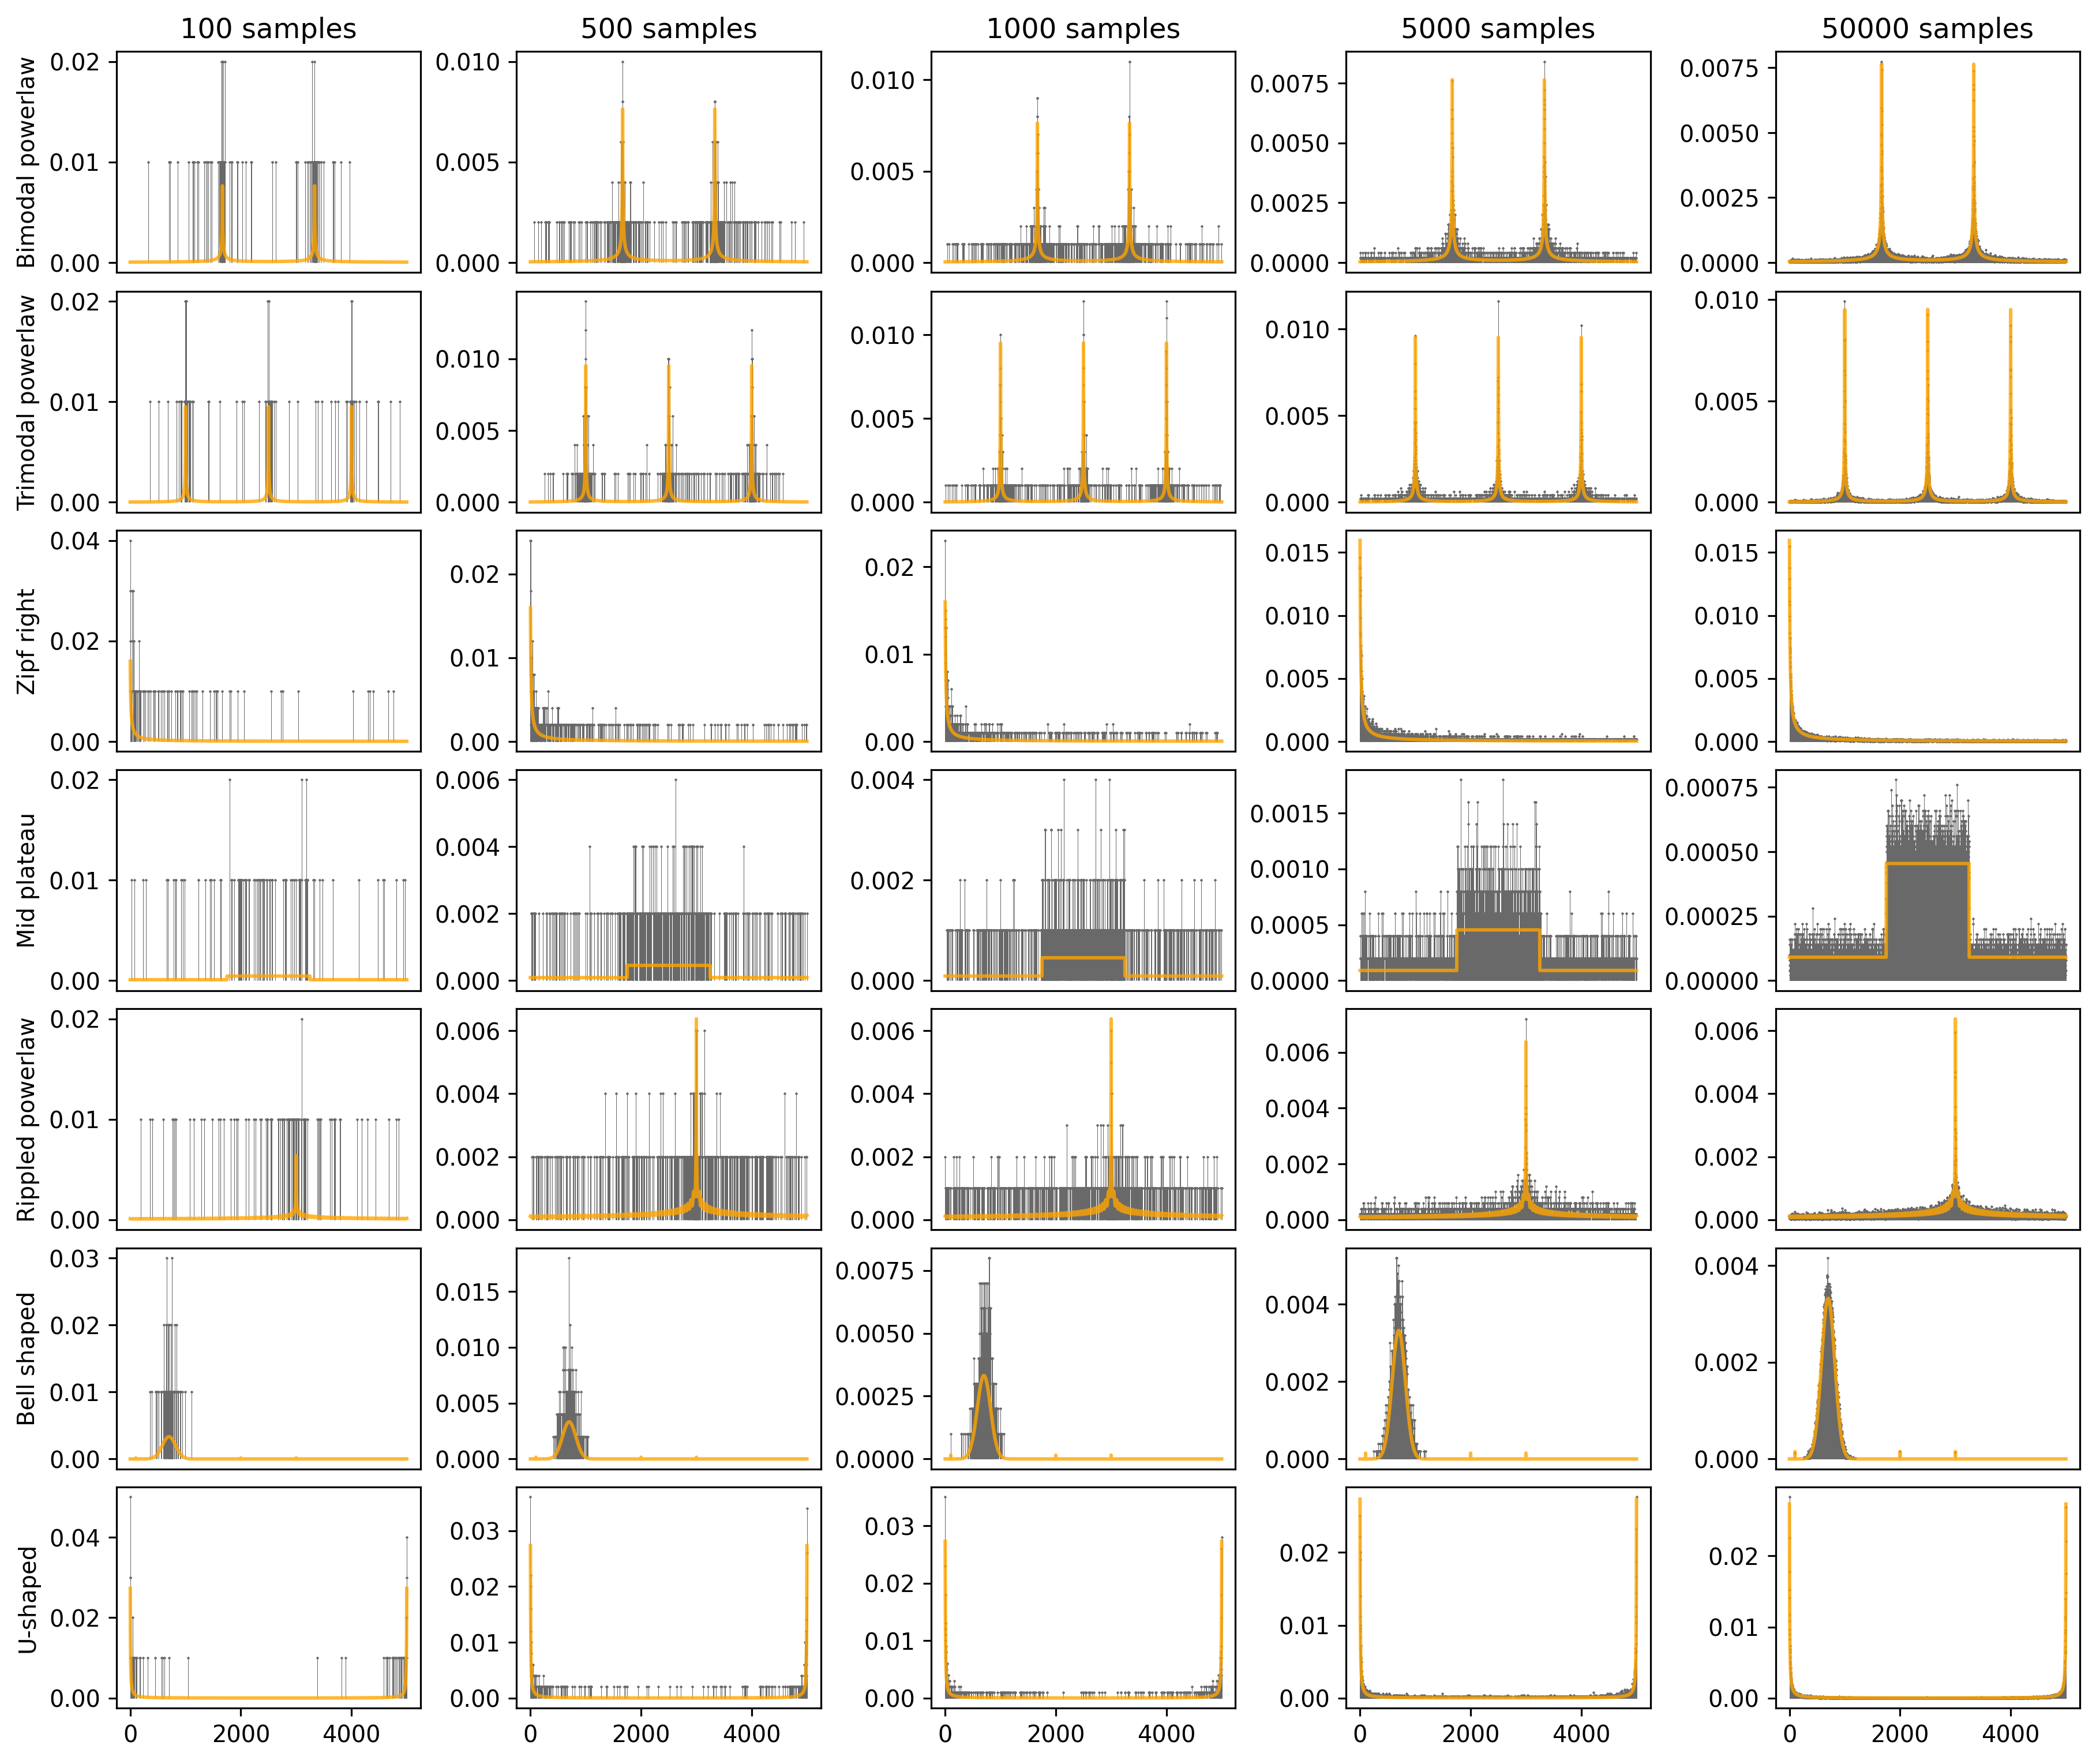

In [15]:
sample_sizes = [100, 500, 1000, 5000, 50000]
n_rows = len(distributions)
n_cols = len(sample_sizes)
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(2.5 * n_cols, 1.5 * n_rows))

for i, (dist_name, dist_weights) in enumerate(distributions):
    # plot the density together with empirical frequencies
    for j, sample_size in enumerate(sample_sizes):
        samples = sample_from_weights(dist_weights, n=sample_size)
        empirical_hist = np.bincount(samples, minlength=max_val)
        empirical_hist = empirical_hist.astype(float) / np.sum(empirical_hist)

        plot_empirical_hist(empirical_hist, axs[i, j])
        axs[i, j].plot(xs, dist_weights, color=weights_color, alpha=0.8)

        if j == 0:
            axs[i, j].set_ylabel(dist_name)
        if i == 0:
            axs[i, j].set_title(f'{sample_size} samples')
        if i < n_rows - 1:
            axs[i, j].tick_params(bottom=False, labelbottom=False)

plt.show()


# Plot modes

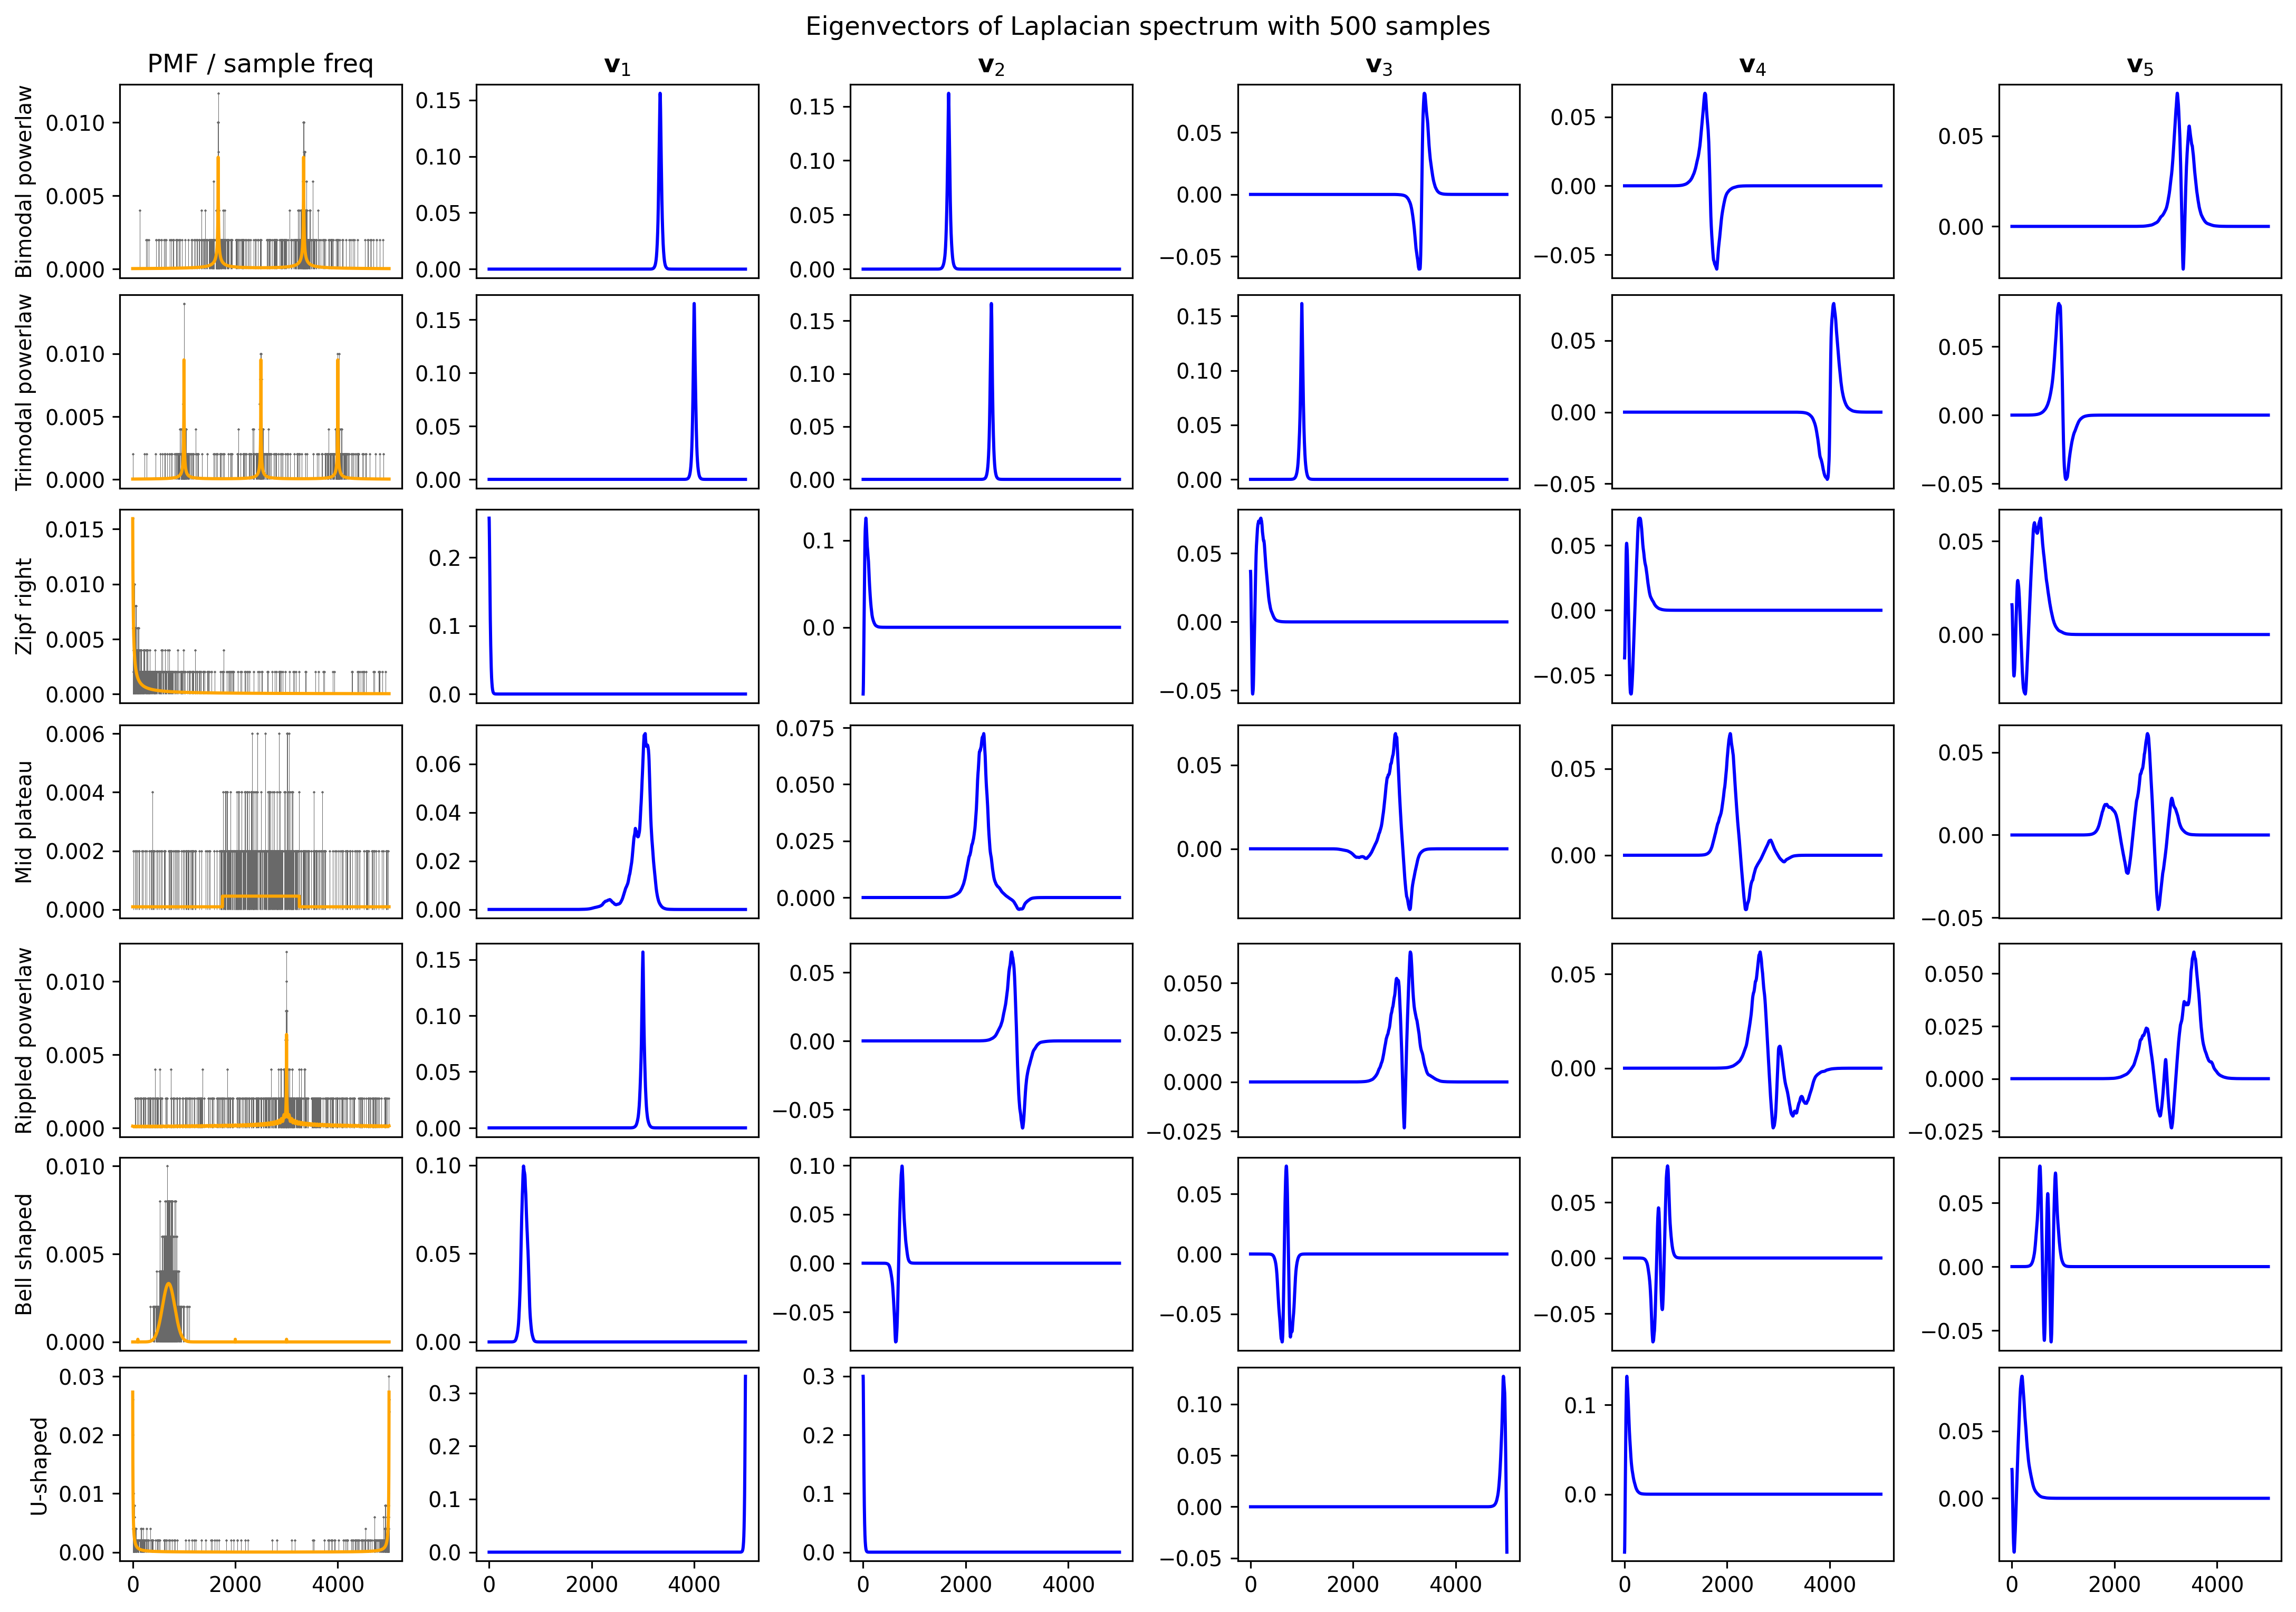

In [16]:
n_rows = len(distributions)
n_cols = 6
n_samples = 500
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(2.5 * n_cols, 1.5 * n_rows))
fig.suptitle(f'Eigenvectors of Laplacian spectrum with {n_samples} samples')

for i, (dist_name, dist_weights) in enumerate(distributions):
    samples = sample_from_weights(dist_weights, n=n_samples)
    empirical_hist = np.bincount(samples, minlength=dist_weights.size)
    empirical_hist = empirical_hist.astype(float) / np.sum(empirical_hist)
    eigvecs = laplacian_spectrum(empirical_hist, n_cols - 1)

    plot_empirical_hist(empirical_hist, axs[i, 0])
    axs[i, 0].plot(xs, dist_weights, color=weights_color)
    axs[i, 0].set_ylabel(dist_name)
    if i == 0:
        axs[i, 0].set_title("PMF / sample freq")
    if i < n_rows - 1:
        axs[i, 0].tick_params(bottom=False, labelbottom=False)

    for j in range(1, n_cols):
        axs[i, j].plot(xs, eigvecs[:, j-1], color=laplacian_color)
        if i == 0:
            axs[i, j].set_title(f'$\\mathbf{{v}}_{j}$')
        if i < n_rows - 1:
            axs[i, j].tick_params(bottom=False, labelbottom=False)

plt.show()

# Plot projections

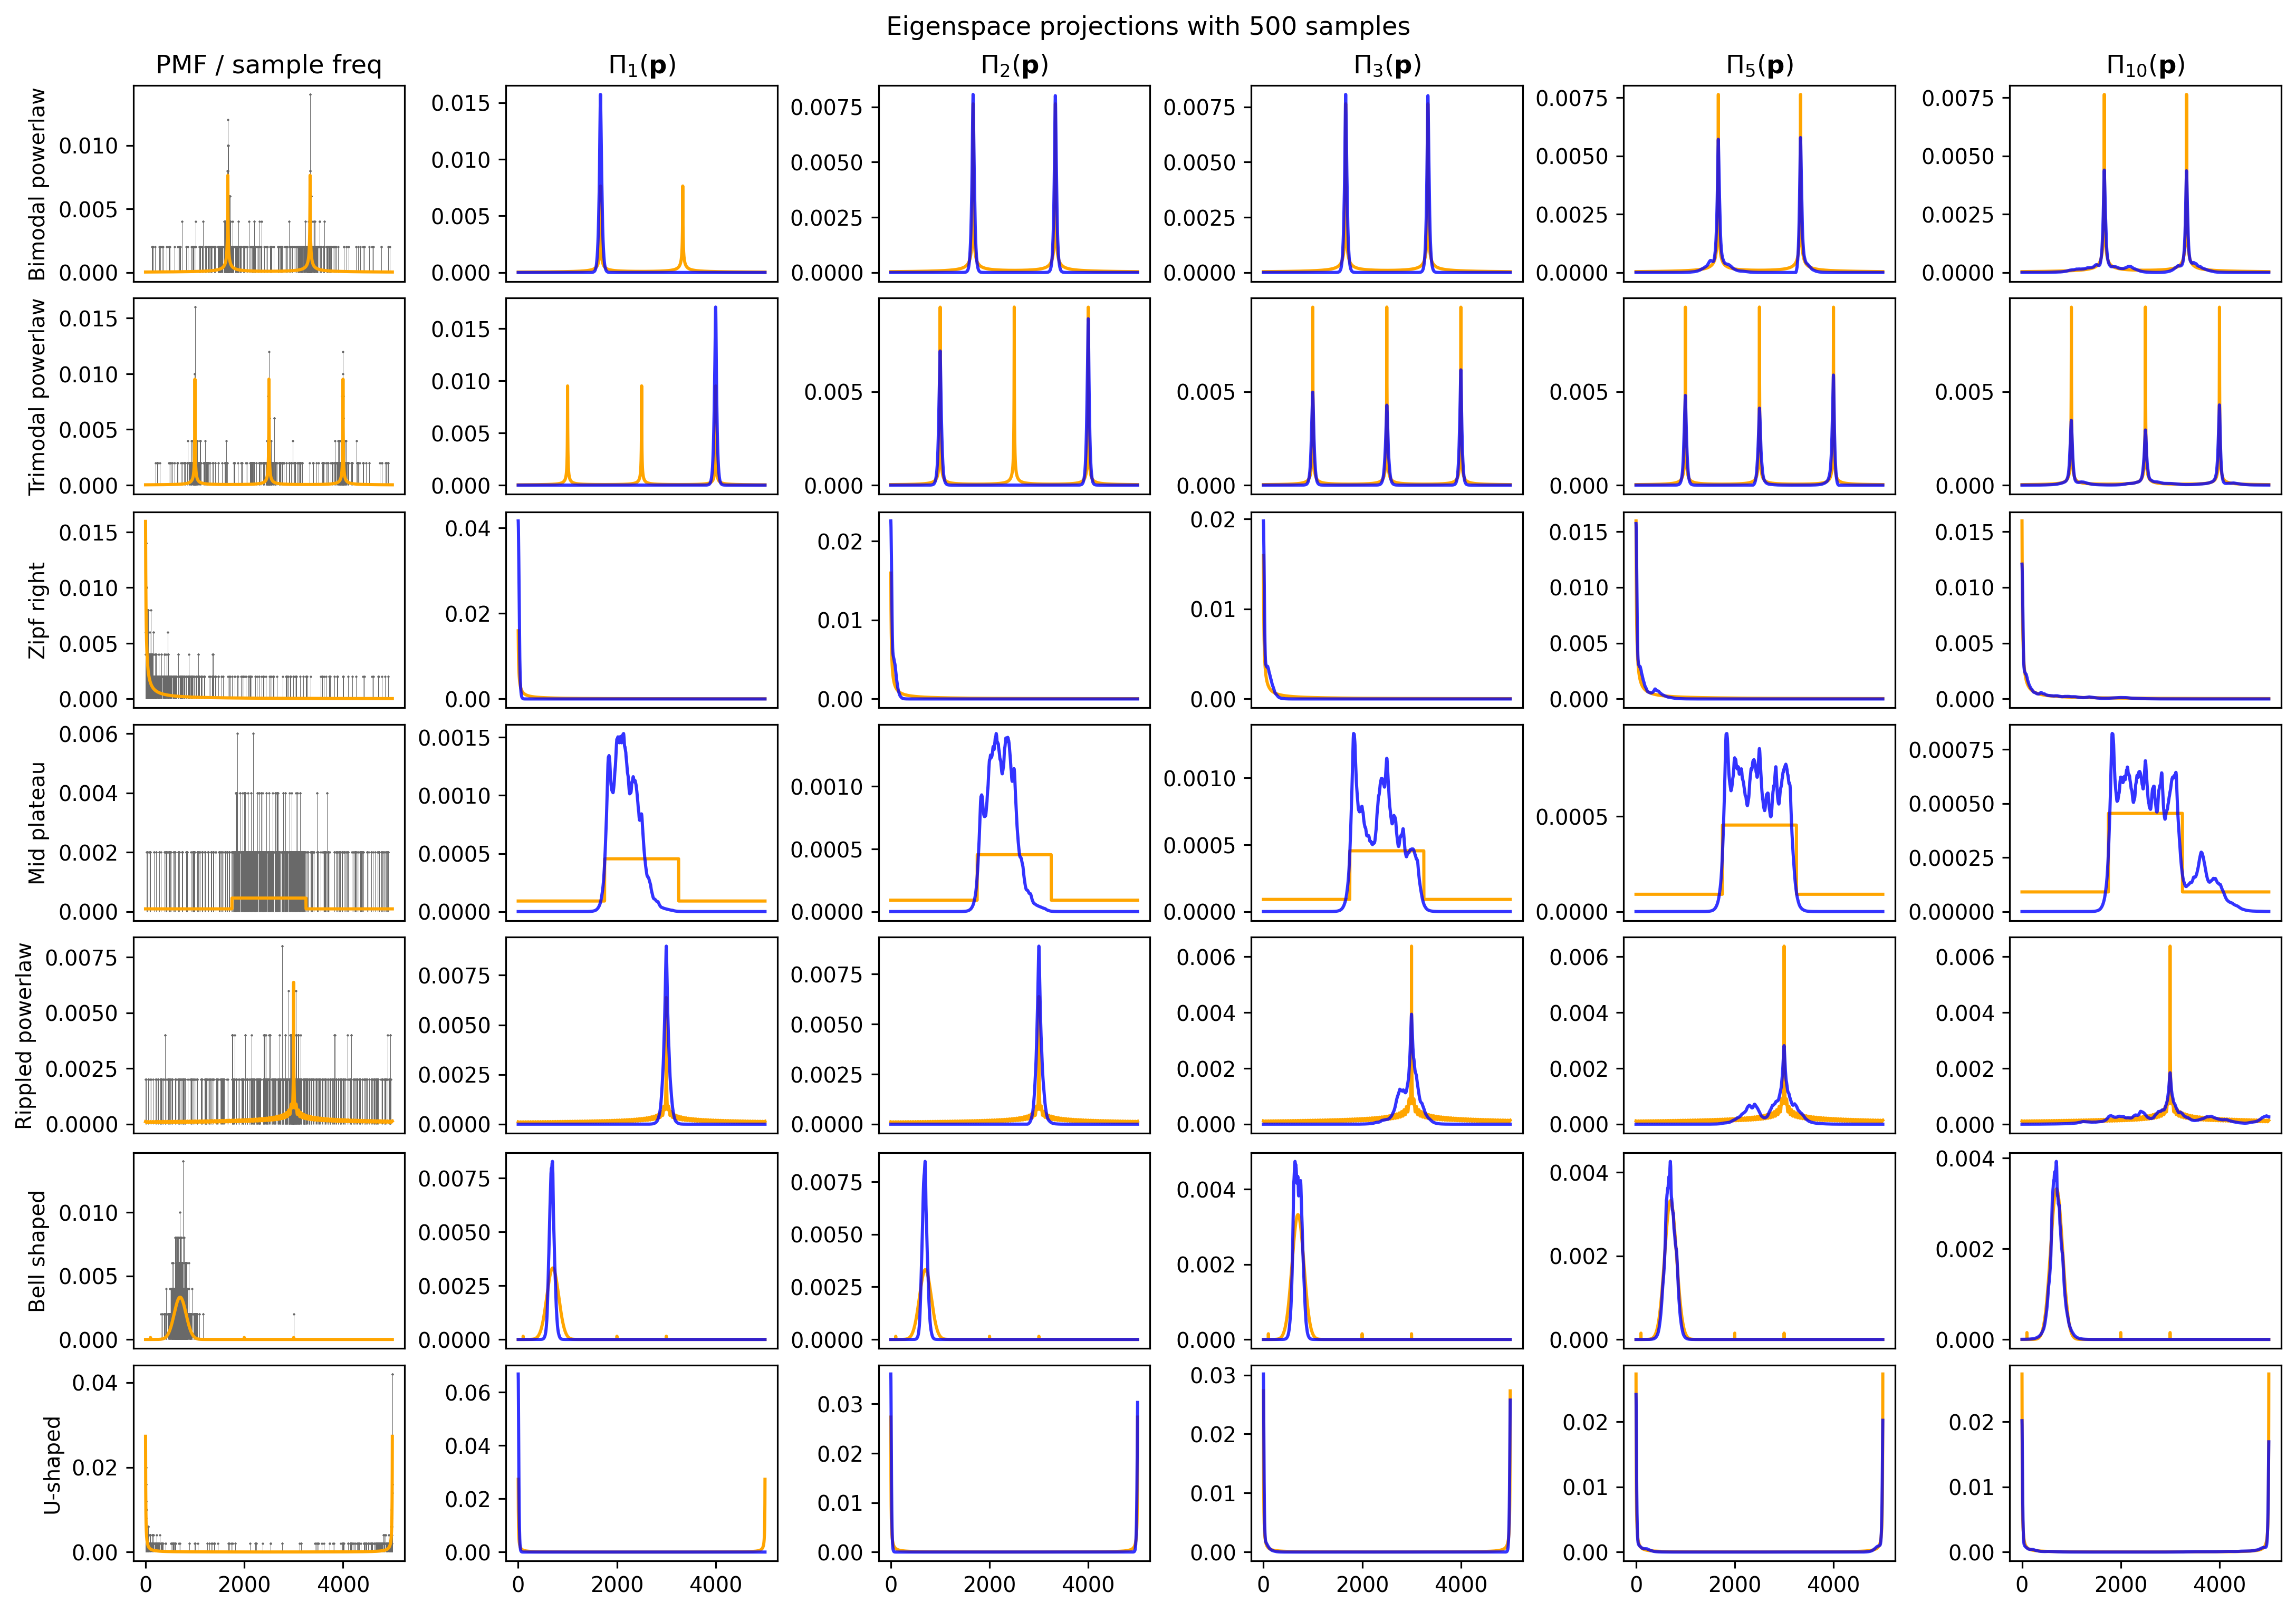

In [17]:
mode_numbers = [1, 2, 3, 5, 10]
n_rows = len(distributions)
n_cols = 1 + len(mode_numbers)
n_samples = 500
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(2.5 * n_cols, 1.5 * n_rows))
fig.suptitle(f"Eigenspace projections with {n_samples} samples")

for i, (dist_name, dist_weights) in enumerate(distributions):
    samples = sample_from_weights(dist_weights, n=n_samples)
    empirical_hist = np.bincount(samples, minlength=max_val)
    empirical_hist = empirical_hist.astype(float) / np.sum(empirical_hist)

    plot_empirical_hist(empirical_hist, axs[i, 0])
    axs[i, 0].plot(xs, dist_weights, color=weights_color)
    axs[i, 0].set_ylabel(dist_name)
    if i == 0:
        axs[i, 0].set_title("PMF / sample freq")
    if i < n_rows - 1:
        axs[i, 0].tick_params(bottom=False, labelbottom=False)

    for j in range(1, n_cols):
        n_modes = mode_numbers[j - 1]

        proj = laplacian_projection(empirical_hist, num_coefs=n_modes)
        proj = normalize(proj)

        axs[i, j].plot(dist_weights, color=weights_color)
        axs[i, j].plot(proj, color=laplacian_color, alpha=0.8)
        if i == 0:
            axs[i, j].set_title(f'$\\Pi_{{{n_modes}}}(\\mathbf{{p}})$')
        if i < n_rows - 1:
            axs[i, j].tick_params(bottom=False, labelbottom=False)

plt.show()

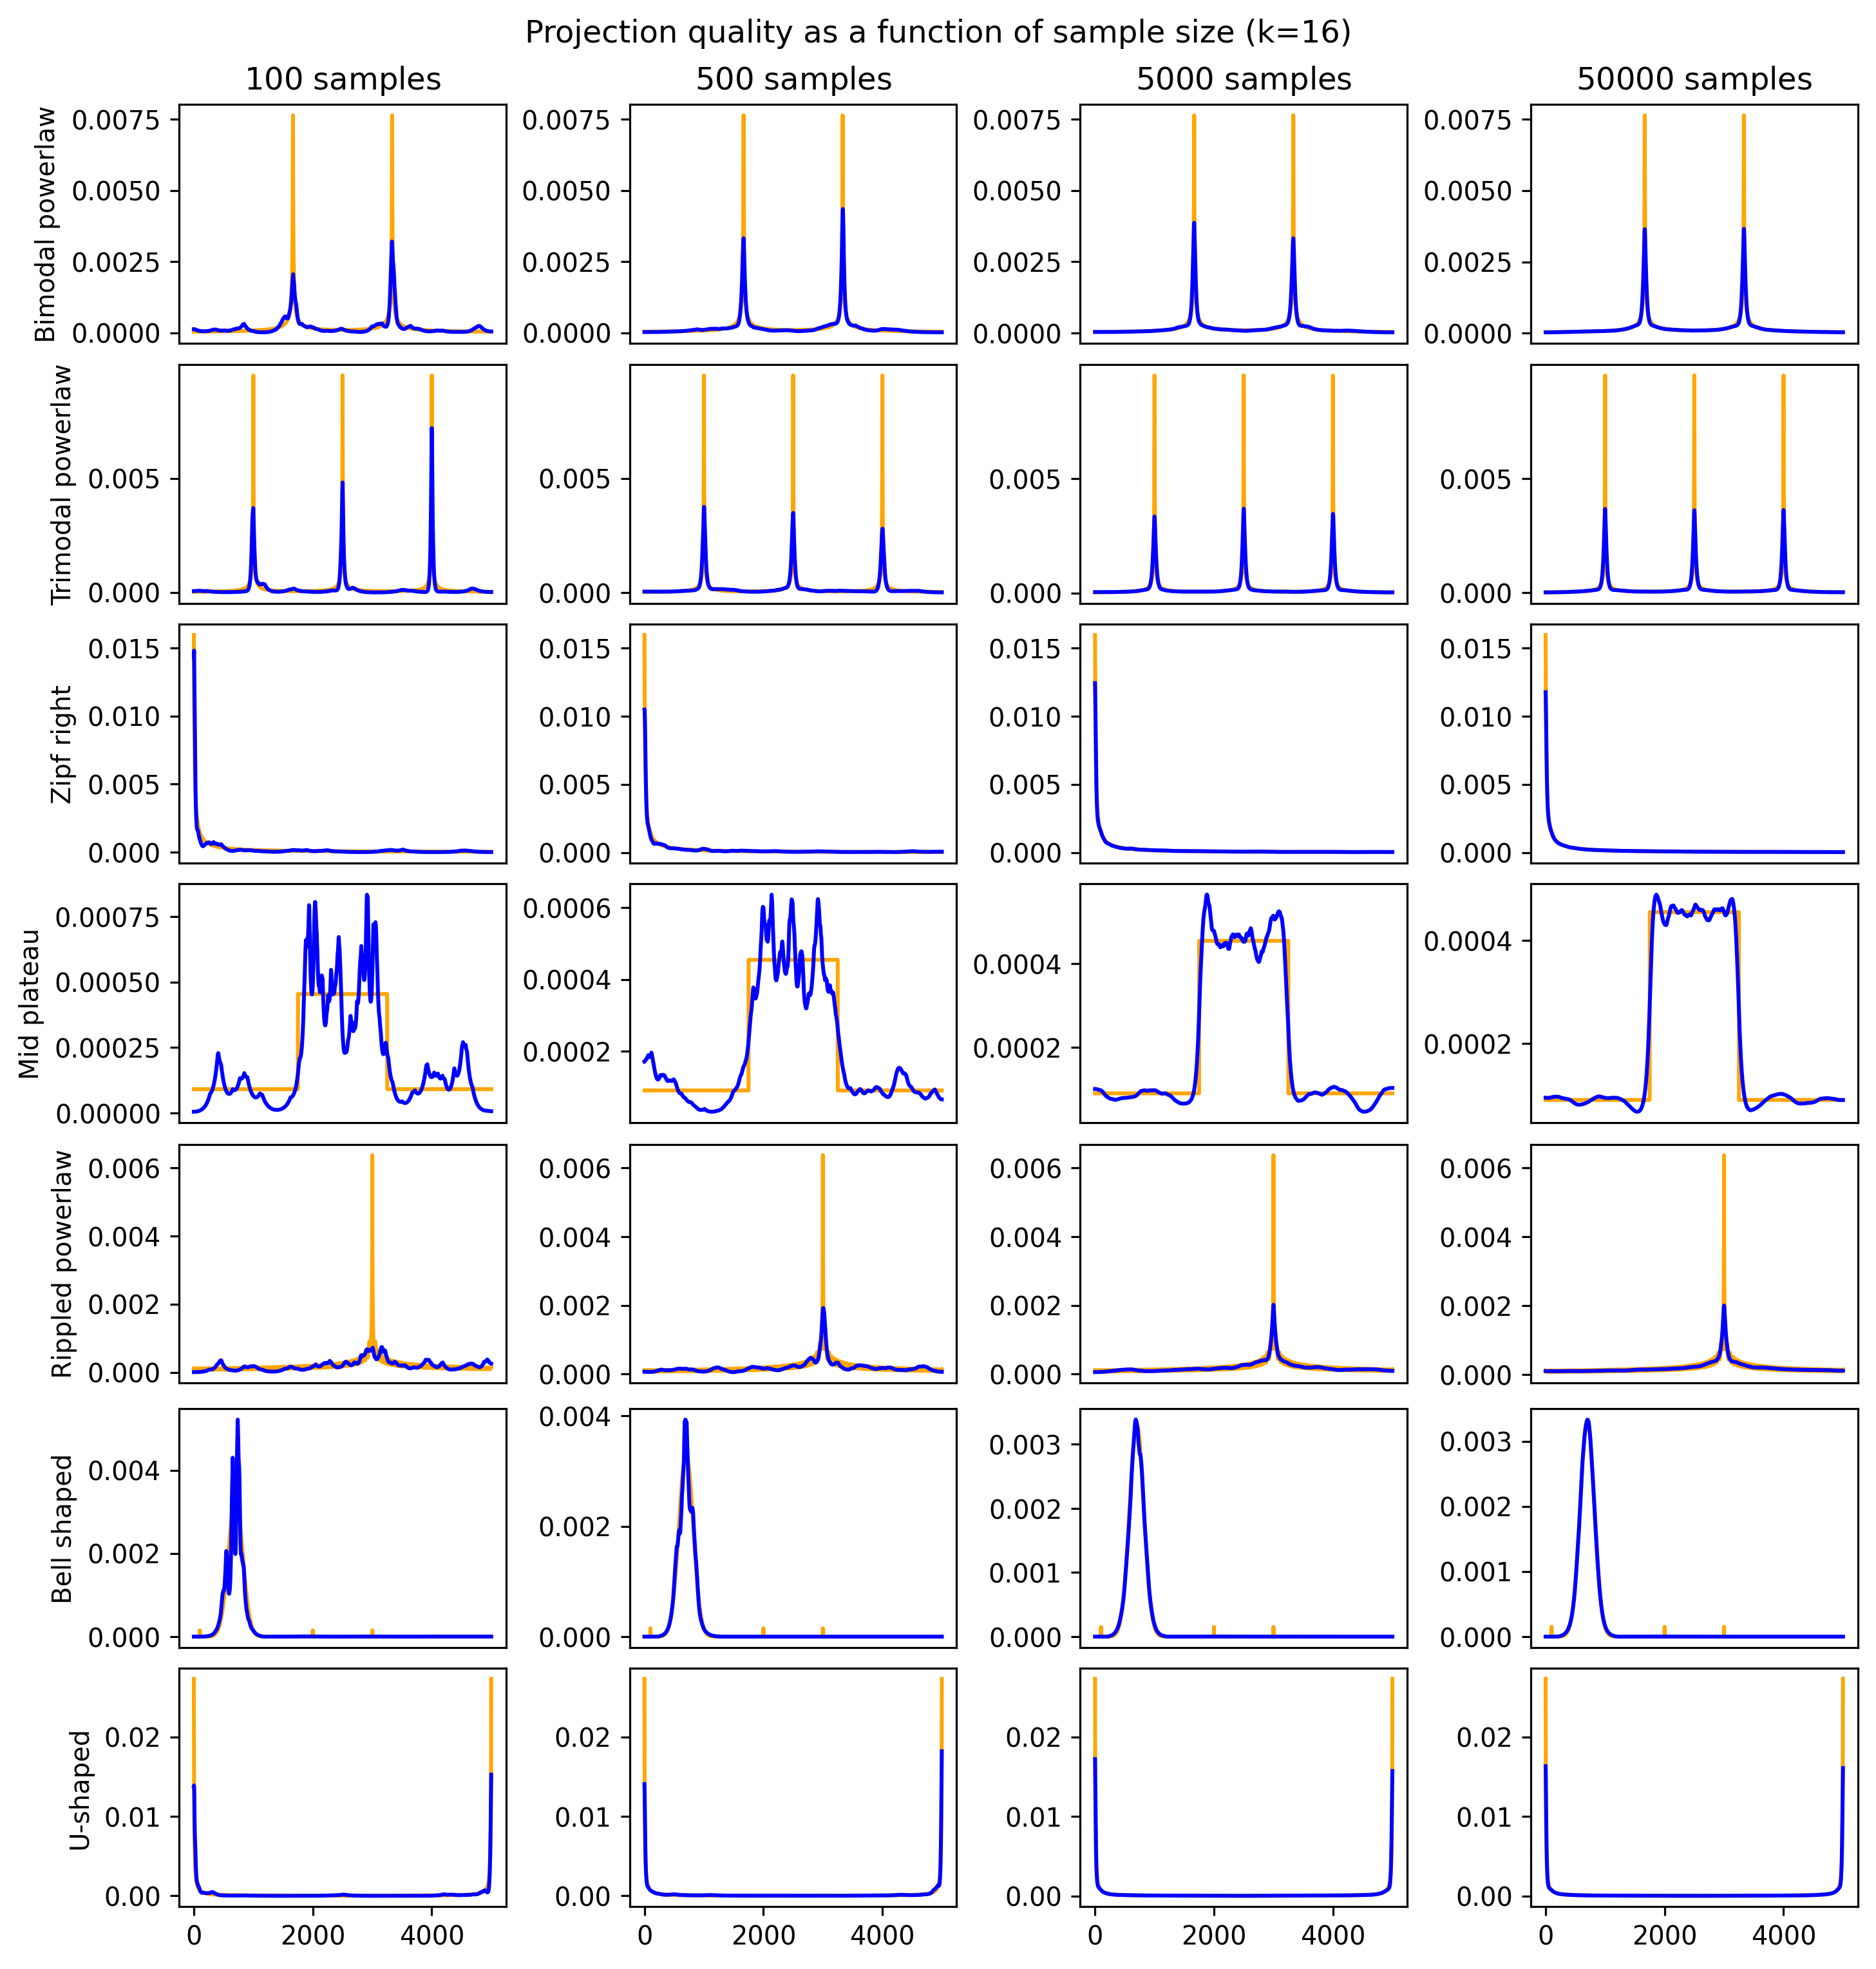

In [18]:
n_modes = 16
sample_sizes = [100, 500, 5000, 50000]
n_rows = len(distributions)
n_cols = len(sample_sizes)
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(2.5 * n_cols, 1.5 * n_rows))

fig.suptitle(f'Projection quality as a function of sample size (k={n_modes})')
for i, (dist_name, dist_weights) in enumerate(distributions):
    axs[i, 0].set_ylabel(dist_name)
    for j in range(n_cols):
        n_samples = sample_sizes[j]
        samples = sample_from_weights(dist_weights, n=n_samples)
        empirical_hist = np.bincount(samples, minlength=max_val)
        empirical_hist = empirical_hist.astype(float) / np.sum(empirical_hist)

        proj = laplacian_projection(empirical_hist, num_coefs=n_modes)
        proj = normalize(proj)

        axs[i, j].plot(dist_weights, color=weights_color)
        axs[i, j].plot(proj, color=laplacian_color)
        if i == 0:
            axs[i, j].set_title(f'${n_samples}$ samples')
        if i < n_rows - 1:
            axs[i, j].tick_params(bottom=False, labelbottom=False)

plt.show()

# Estimator comparison on synthetic data

possible infinite density at lower end
running program with fewer knots
possible infinite density at upper end
running program with fewer knots
possible infinite density at lower end
running program with fewer knots
possible infinite density at upper end
running program with fewer knots
possible infinite density at lower end
running program with fewer knots
possible infinite density at upper end
running program with fewer knots
* convergence problems, smallest number of knots  tried is  13  *
possible infinite density at lower end
running program with fewer knots
possible infinite density at upper end
running program with fewer knots


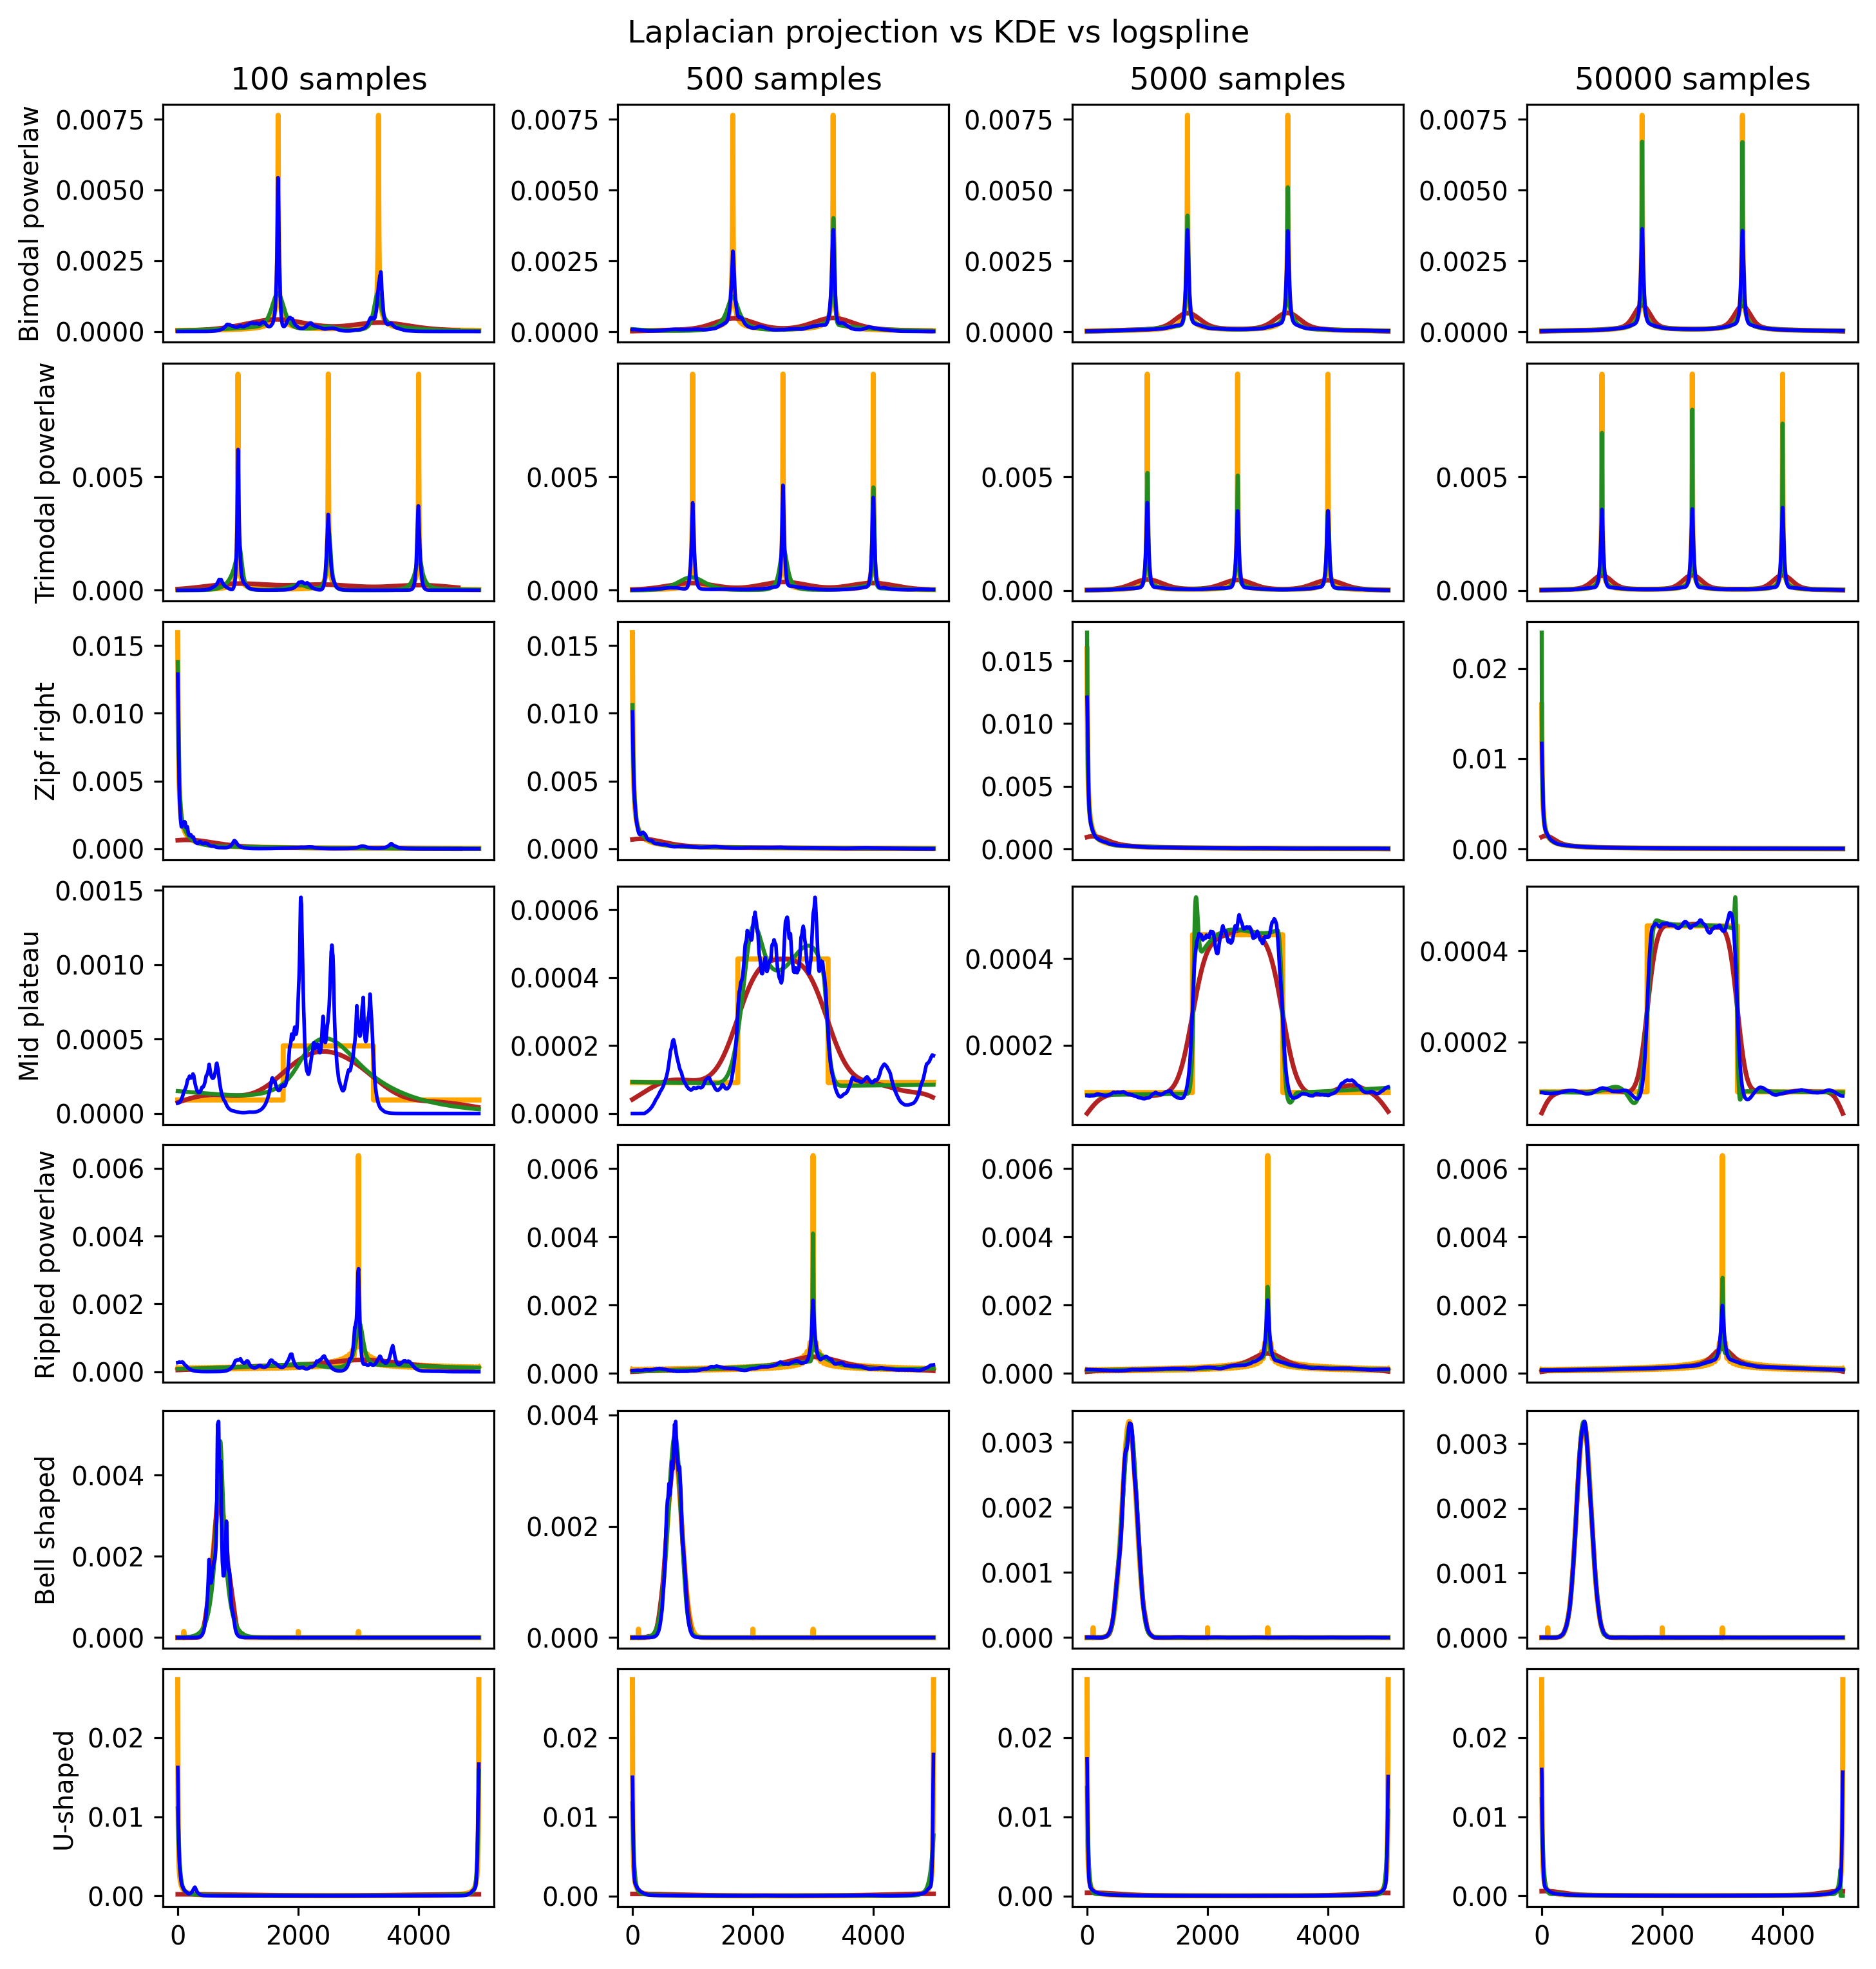

In [19]:
sample_sizes = [100, 500, 5000, 50000]
n_rows = len(distributions)
n_cols = len(sample_sizes)
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(2.5 * n_cols, 1.5 * n_rows))

fig.suptitle(f'Laplacian projection vs KDE vs logspline')
for i, (dist_name, dist_weights) in enumerate(distributions):
    axs[i, 0].set_ylabel(dist_name)
    for j in range(0, n_cols):
        n_samples = sample_sizes[j]
        samples = sample_from_weights(dist_weights, n=n_samples)
        empirical_hist = np.bincount(samples, minlength=dist_weights.size)
        empirical_hist = empirical_hist.astype(float) / np.sum(empirical_hist)

        proj = laplacian_hist_estimator(samples, max_val=dist_weights.size)
        kde_est = kde_curve(samples)
        try:
            lspline_est = logspline_estimator(samples, dist_weights.size)
        except:
            lspline_est = None

        axs[i, j].plot(dist_weights, color=weights_color, linewidth=2.)
        axs[i, j].plot(kde_est, color=kde_color, linewidth=1.8)
        if lspline_est is not None:
            axs[i, j].plot(lspline_est, color=logspline_color, linewidth=1.6)
        axs[i, j].plot(proj, color=laplacian_color, linewidth=1.4)
        if i == 0:
            axs[i, j].set_title(f'${n_samples}$ samples')
        if i < n_rows - 1:
            axs[i, j].tick_params(bottom=False, labelbottom=False)

plt.show()

# Logspline reliability

In [20]:
import os
import contextlib

num_trials = 1000
sample_sizes =  [100, 250, 500, 1000]

with open(os.devnull, 'w') as devnull:
    results = []
    for n_samples in sample_sizes:
        for dist_name, dist_weights in distributions:
            for _ in tqdm(range(num_trials), desc=f'{dist_name} {n_samples} samples', leave=False):
                samples = sample_from_weights(dist_weights, n=n_samples)
                try:
                    with contextlib.redirect_stdout(devnull):
                        with contextlib.redirect_stderr(devnull):
                            lspline_est = logspline_estimator(samples, dist_weights.size)
                    results.append({
                        'dist_name': dist_name,
                        'n_samples': n_samples,
                        'success': 1
                    })
                except:
                    results.append({
                        'dist_name': dist_name,
                        'n_samples': n_samples,
                        'success': 0
                    })

Bimodal powerlaw 100 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Trimodal powerlaw 100 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Zipf right 100 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Mid plateau 100 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Rippled powerlaw 100 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Bell shaped 100 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

U-shaped 100 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Bimodal powerlaw 250 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Trimodal powerlaw 250 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Zipf right 250 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Mid plateau 250 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Rippled powerlaw 250 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Bell shaped 250 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

U-shaped 250 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Bimodal powerlaw 500 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Trimodal powerlaw 500 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Zipf right 500 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Mid plateau 500 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Rippled powerlaw 500 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Bell shaped 500 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

U-shaped 500 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Bimodal powerlaw 1000 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Trimodal powerlaw 1000 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Zipf right 1000 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Mid plateau 1000 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Rippled powerlaw 1000 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Bell shaped 1000 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

U-shaped 1000 samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
results = pl.DataFrame(results)
results.pivot(index='dist_name', on='n_samples', values='success', aggregate_function='mean')

shape: (7, 5)
┌───────────────────┬──────┬───────┬───────┬───────┐
│ dist_name         ┆ 100  ┆ 250   ┆ 500   ┆ 1000  │
│ ---               ┆ ---  ┆ ---   ┆ ---   ┆ ---   │
│ str               ┆ f64  ┆ f64   ┆ f64   ┆ f64   │
╞═══════════════════╪══════╪═══════╪═══════╪═══════╡
│ Bimodal powerlaw  ┆ 1.0  ┆ 1.0   ┆ 1.0   ┆ 1.0   │
│ Trimodal powerlaw ┆ 1.0  ┆ 1.0   ┆ 1.0   ┆ 1.0   │
│ Zipf right        ┆ 1.0  ┆ 1.0   ┆ 1.0   ┆ 1.0   │
│ Mid plateau       ┆ 1.0  ┆ 1.0   ┆ 1.0   ┆ 1.0   │
│ Rippled powerlaw  ┆ 1.0  ┆ 1.0   ┆ 1.0   ┆ 1.0   │
│ Bell shaped       ┆ 1.0  ┆ 1.0   ┆ 1.0   ┆ 1.0   │
│ U-shaped          ┆ 0.98 ┆ 0.915 ┆ 0.999 ┆ 0.971 │
└───────────────────┴──────┴───────┴───────┴───────┘

# As embeddings

In [22]:
weights = weights_bimodal_powerlaw()
samples = sample_from_weights(weights, n=500)

empirical_hist = np.bincount(samples, minlength=weights.size)
empirical_hist = empirical_hist.astype(float) / np.sum(empirical_hist)

evecs = laplacian_spectrum(empirical_hist, 2)

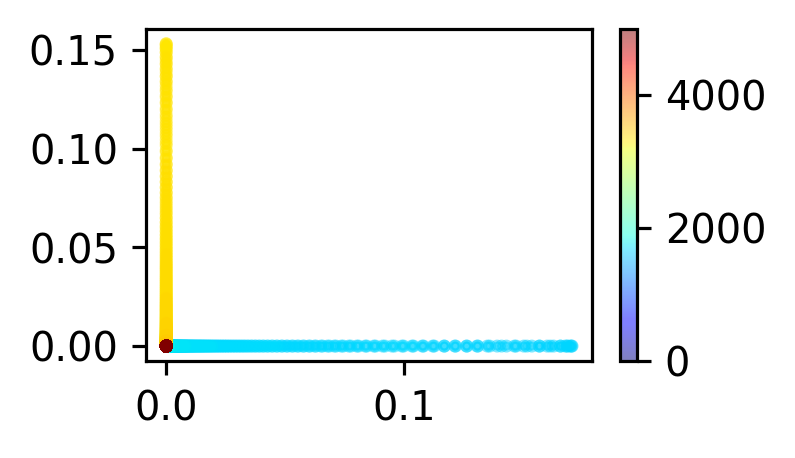

In [23]:
plt.figure(figsize=(2.5, 1.5))
plt.scatter(evecs[:, 0], evecs[:, 1], s=5, c=xs, alpha=0.5, cmap='jet')
plt.colorbar()

In [24]:
weights = weights_trimodal_powerlaw()
samples = sample_from_weights(weights, n=500)

empirical_hist = np.bincount(samples, minlength=max_val)
empirical_hist = empirical_hist.astype(float) / np.sum(empirical_hist)

evecs = laplacian_spectrum(empirical_hist, 3)

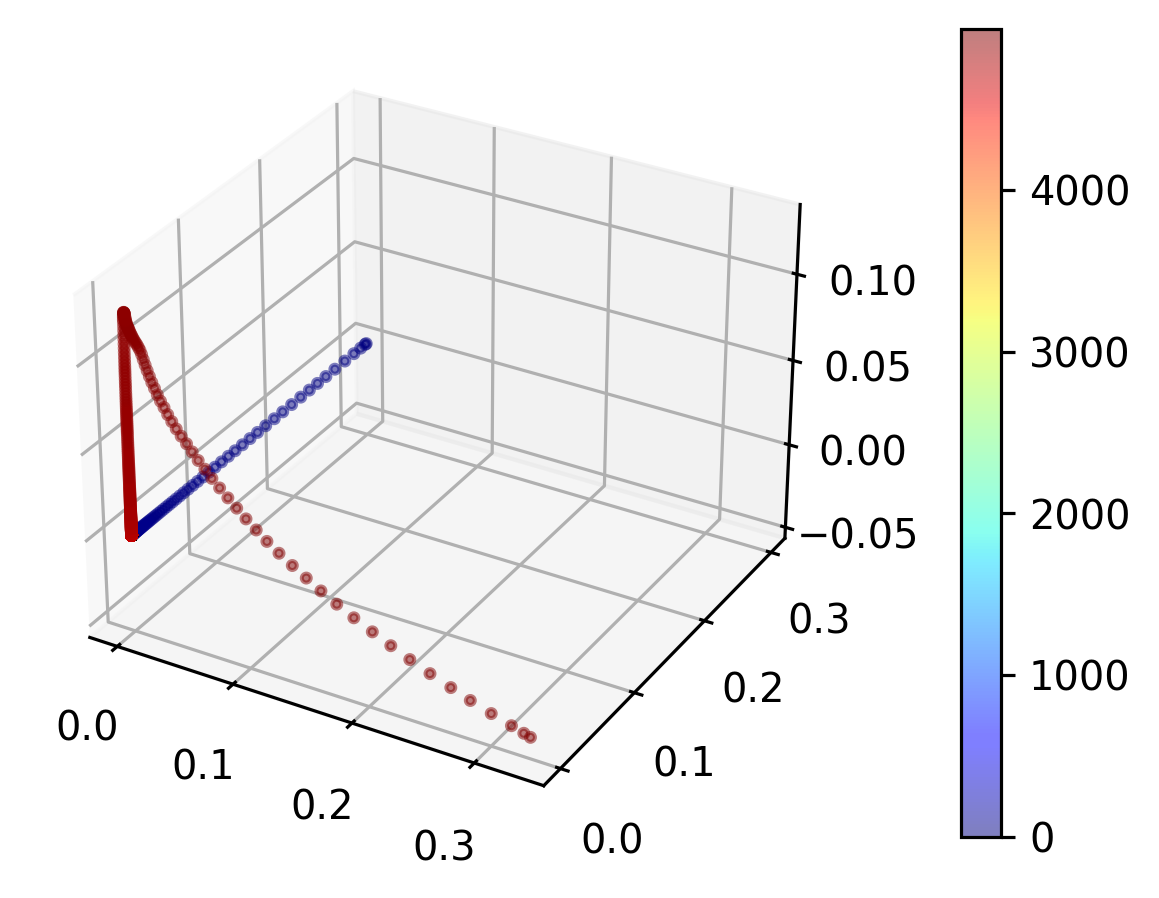

In [25]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection='3d')
p = ax.scatter(eigvecs[:, 0], eigvecs[:, 1], eigvecs[:, 2], s=5, c=xs, alpha=0.5, cmap='jet')
fig.colorbar(p, ax=ax)

# Real data

In [26]:
from ucimlrepo import fetch_ucirepo
import math

## Spambase

In [44]:
spambase = fetch_ucirepo(id=94)
X = spambase.data.features
y = spambase.data.targets

In [45]:
freq_cols = [col for col in X.columns if 'freq' in col]
X.loc[:, freq_cols] = X[freq_cols].apply(lambda col: np.round(100 * col))
X = X.astype(np.int32)
X.head(3)

word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0               0                 64             64             0   
1              21                 28             50             0   
2               6                  0             71             0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0             32               0                 0                   0   
1             14              28                21                   7   
2            123              19                19                  12   

   word_freq_order  word_freq_mail  ...  word_freq_conference  char_freq_;  \
0                0               0  ...                     0            0   
1                0              94  ...                     0            0   
2               64              25  ...                     0            1   

   char_freq_(  char_freq_[  char_freq_!  char_freq_$  char_freq_#  \
0            0            0           78            0            0   
1           13            0           37           18            5   
2           14            0           28           18            1   

   capital_run_length_average  capital_run_length_longest  \
0                           3                          61   
1                           5                         101   
2                           9                         485   

   capital_run_length_total  
0                       278  
1                      1028  
2                      2259  

[3 rows x 57 columns]

In [46]:
(X > 0).sum().to_frame().transpose()

word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            1053                898           1888            47   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           1748             999               807                 824   

   word_freq_order  word_freq_mail  ...  word_freq_conference  char_freq_;  \
0              773            1302  ...                   203          787   

   char_freq_(  char_freq_[  char_freq_!  char_freq_$  char_freq_#  \
0         2712          522         2252         1394          742   

   capital_run_length_average  capital_run_length_longest  \
0                        4601                        4601   

   capital_run_length_total  
0                      4601  

[1 rows x 57 columns]

R callback write-console: Error in oldlogspline(x, lbound = jlx, ubound = jux) : * no convergence
  
R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1:   
R callback write-console: In (function (x, lbound, ubound, maxknots = 0, knots, nknots = 0,  :  
R callback write-console: 
   
R callback write-console:  too much data close together
  
R callback write-console: 2:   
R callback write-console: In (function (x, lbound, ubound, maxknots = 0, knots, nknots = 0,  :  
R callback write-console: 
   
R callback write-console:  re-ran with oldlogspline
  
R callback write-console: 3:   
R callback write-console: In (function (x, lbound, ubound, maxknots = 0, knots, nknots = 0,  :  
R callback write-console: 
   
R callback write-console:  too much data close together
  


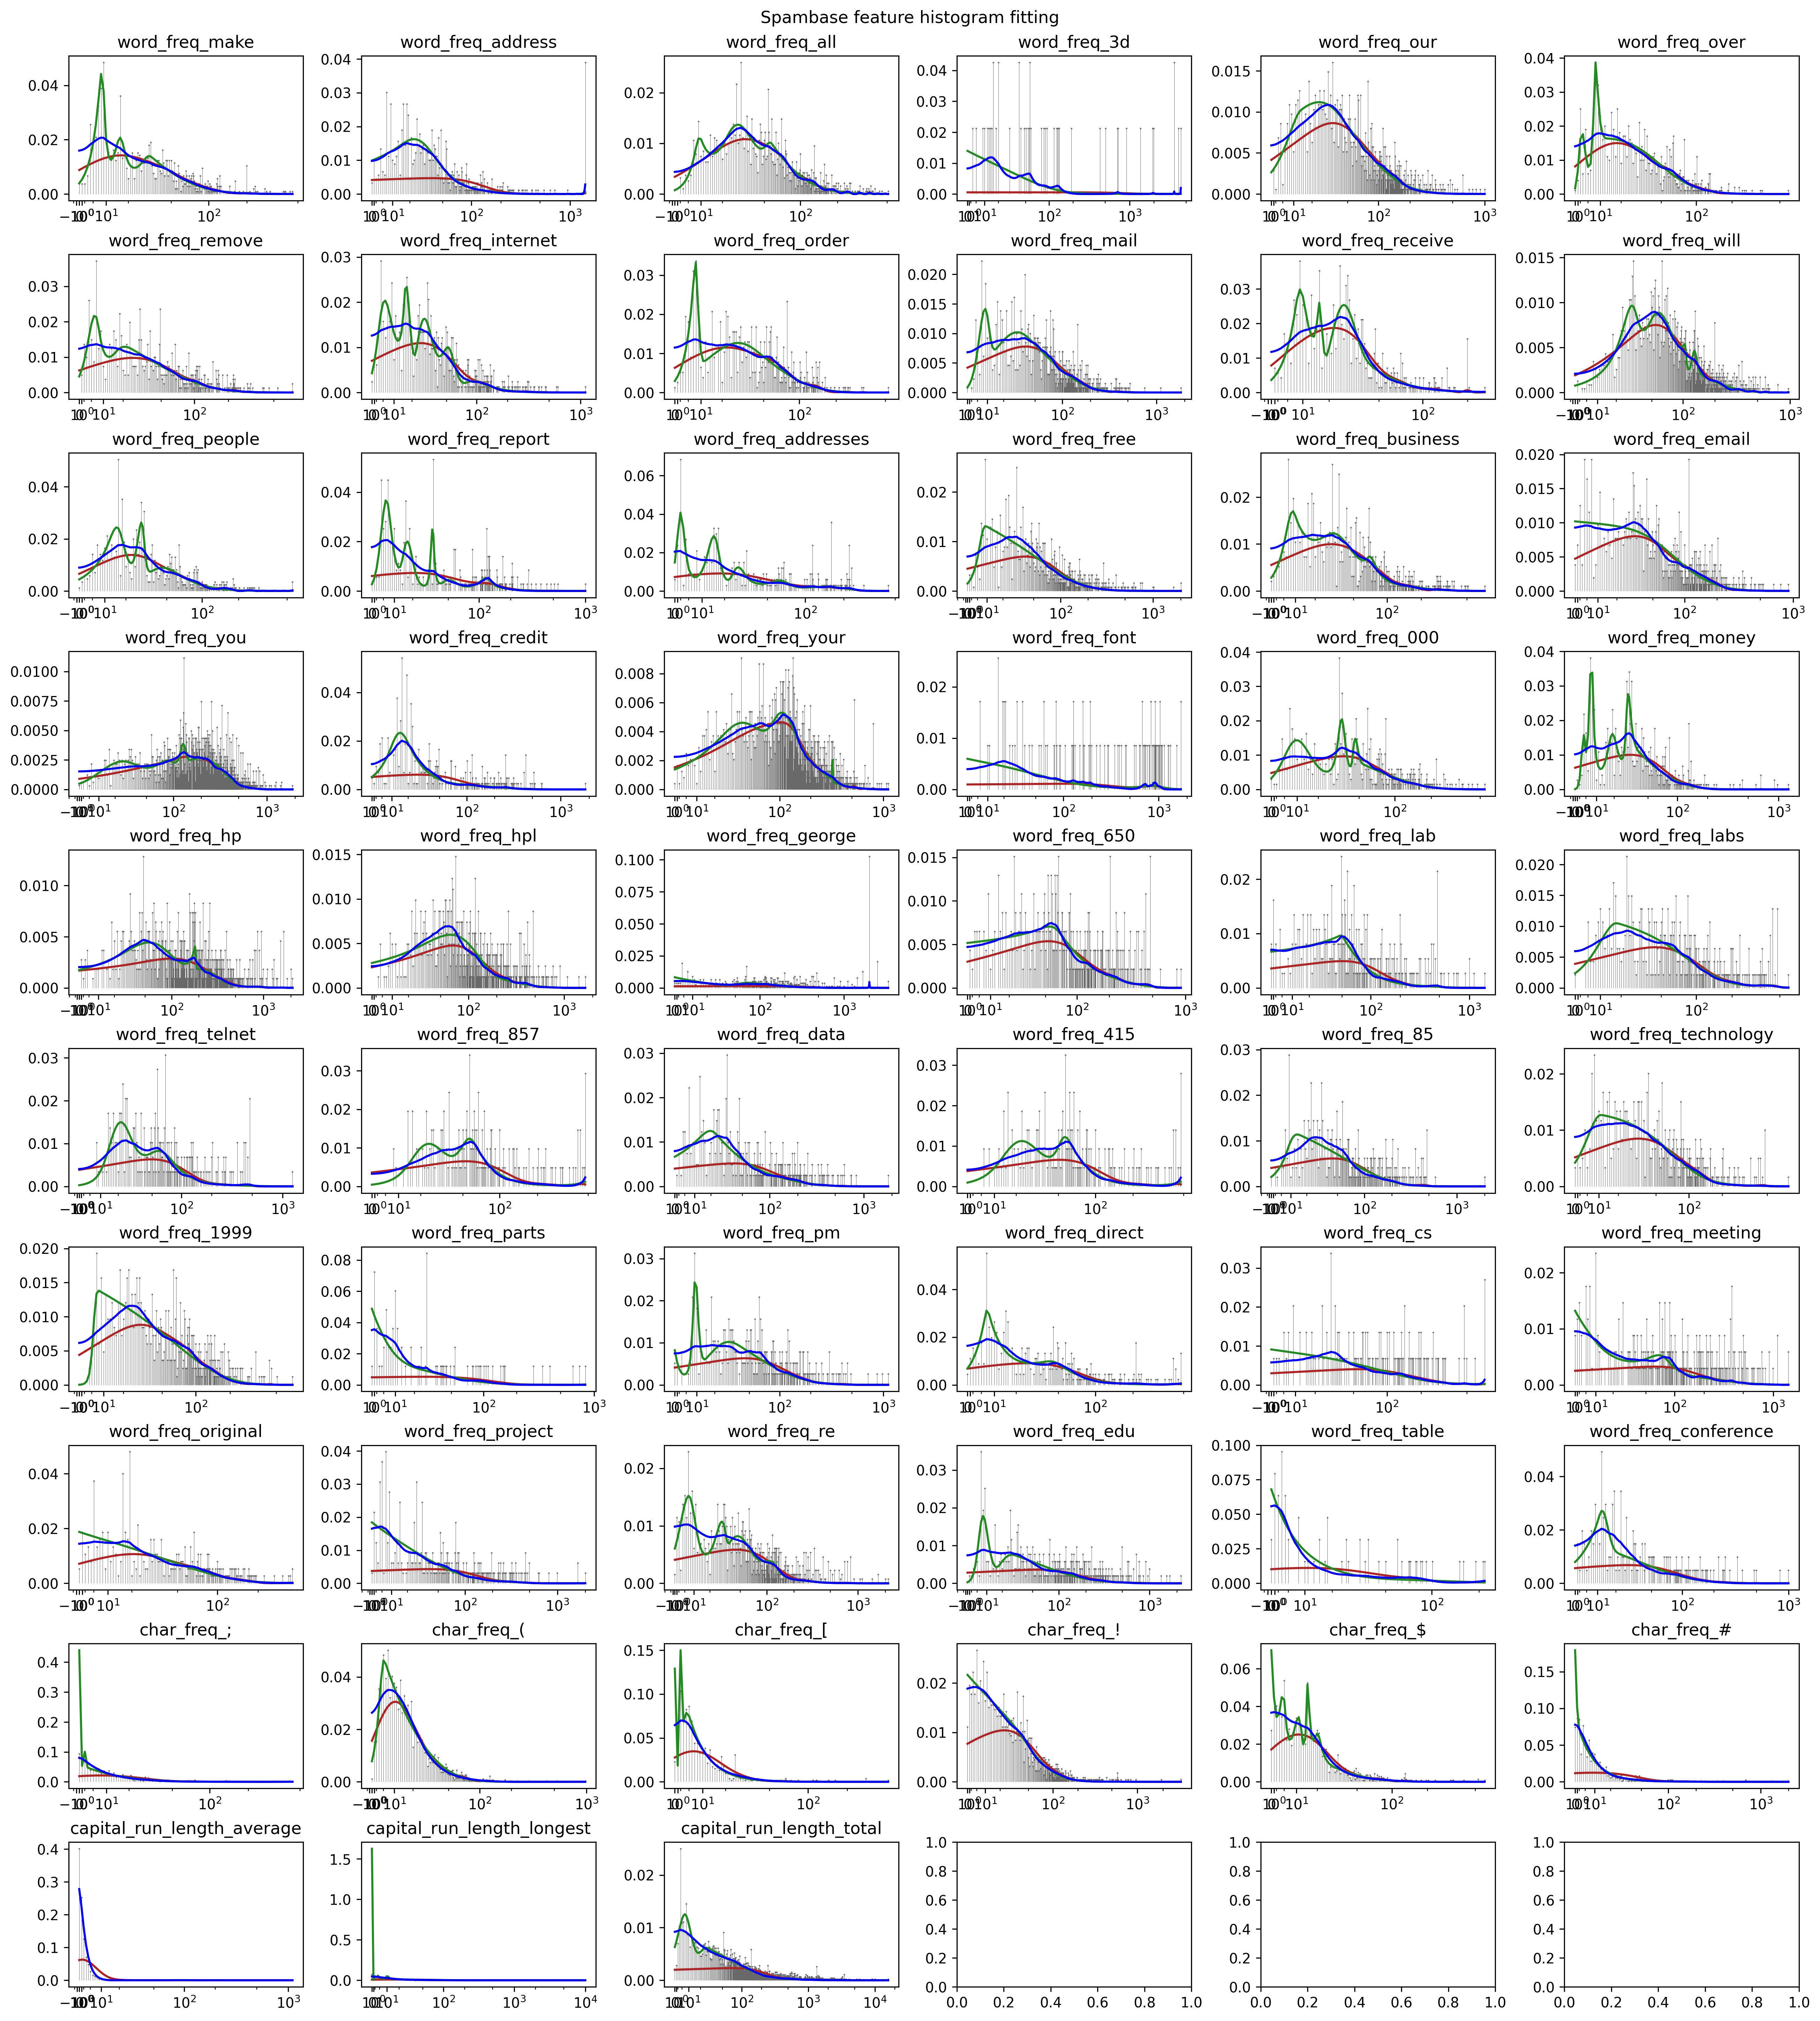

In [50]:
n_vars = len(X.columns)
n_samples = len(X)

n_cols = math.ceil(math.sqrt(n_vars) / 1.4)
n_rows = math.ceil(n_vars / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(3 * n_cols, 2 * n_rows))

fig.suptitle(f'Spambase feature histogram fitting')
for col_name, ax in zip(X.columns, axs.ravel()):
    samples = X.loc[:, col_name].to_numpy()
    samples = samples[samples > 0] - 1
    max_val = np.max(samples).item()
    empirical_hist = np.bincount(samples, minlength=max_val)
    empirical_hist = empirical_hist.astype(float) / np.sum(empirical_hist)

    proj = laplacian_hist_estimator(samples)
    kde_est = kde_curve(samples)
    try:
        lspline_est = logspline_estimator(samples, max_val)
    except:
        lspline_est = None

    plot_empirical_hist(empirical_hist, ax)
    ax.plot(kde_est, color=kde_color)
    if lspline_est is not None:
        ax.plot(lspline_est, color=logspline_color)
    ax.plot(proj, color=laplacian_color)
    ax.set_xscale('asinh', linear_width=20)
    ax.set_title(col_name)

plt.show()

# Bank marketing

In [31]:
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = bank_marketing.data.targets

In [32]:
balance = X['balance'].to_numpy()
balance = balance[balance != 0]
shift = np.min(balance)
balance_shifted = balance - shift
max_val = np.max(balance_shifted).item() + 1

In [33]:
min_balance = np.min(balance)
max_balance = np.max(balance)
xs = np.arange(min_balance, max_balance + 1)

In [34]:
n_rows = 2
n_cols = 3
subsample_sizes = np.geomspace(0.01 * len(balance), len(balance), n_rows * n_cols)
subsample_pct = (subsample_sizes / len(balance) * 100).astype(int)
subsample_sizes = subsample_sizes.astype(int)

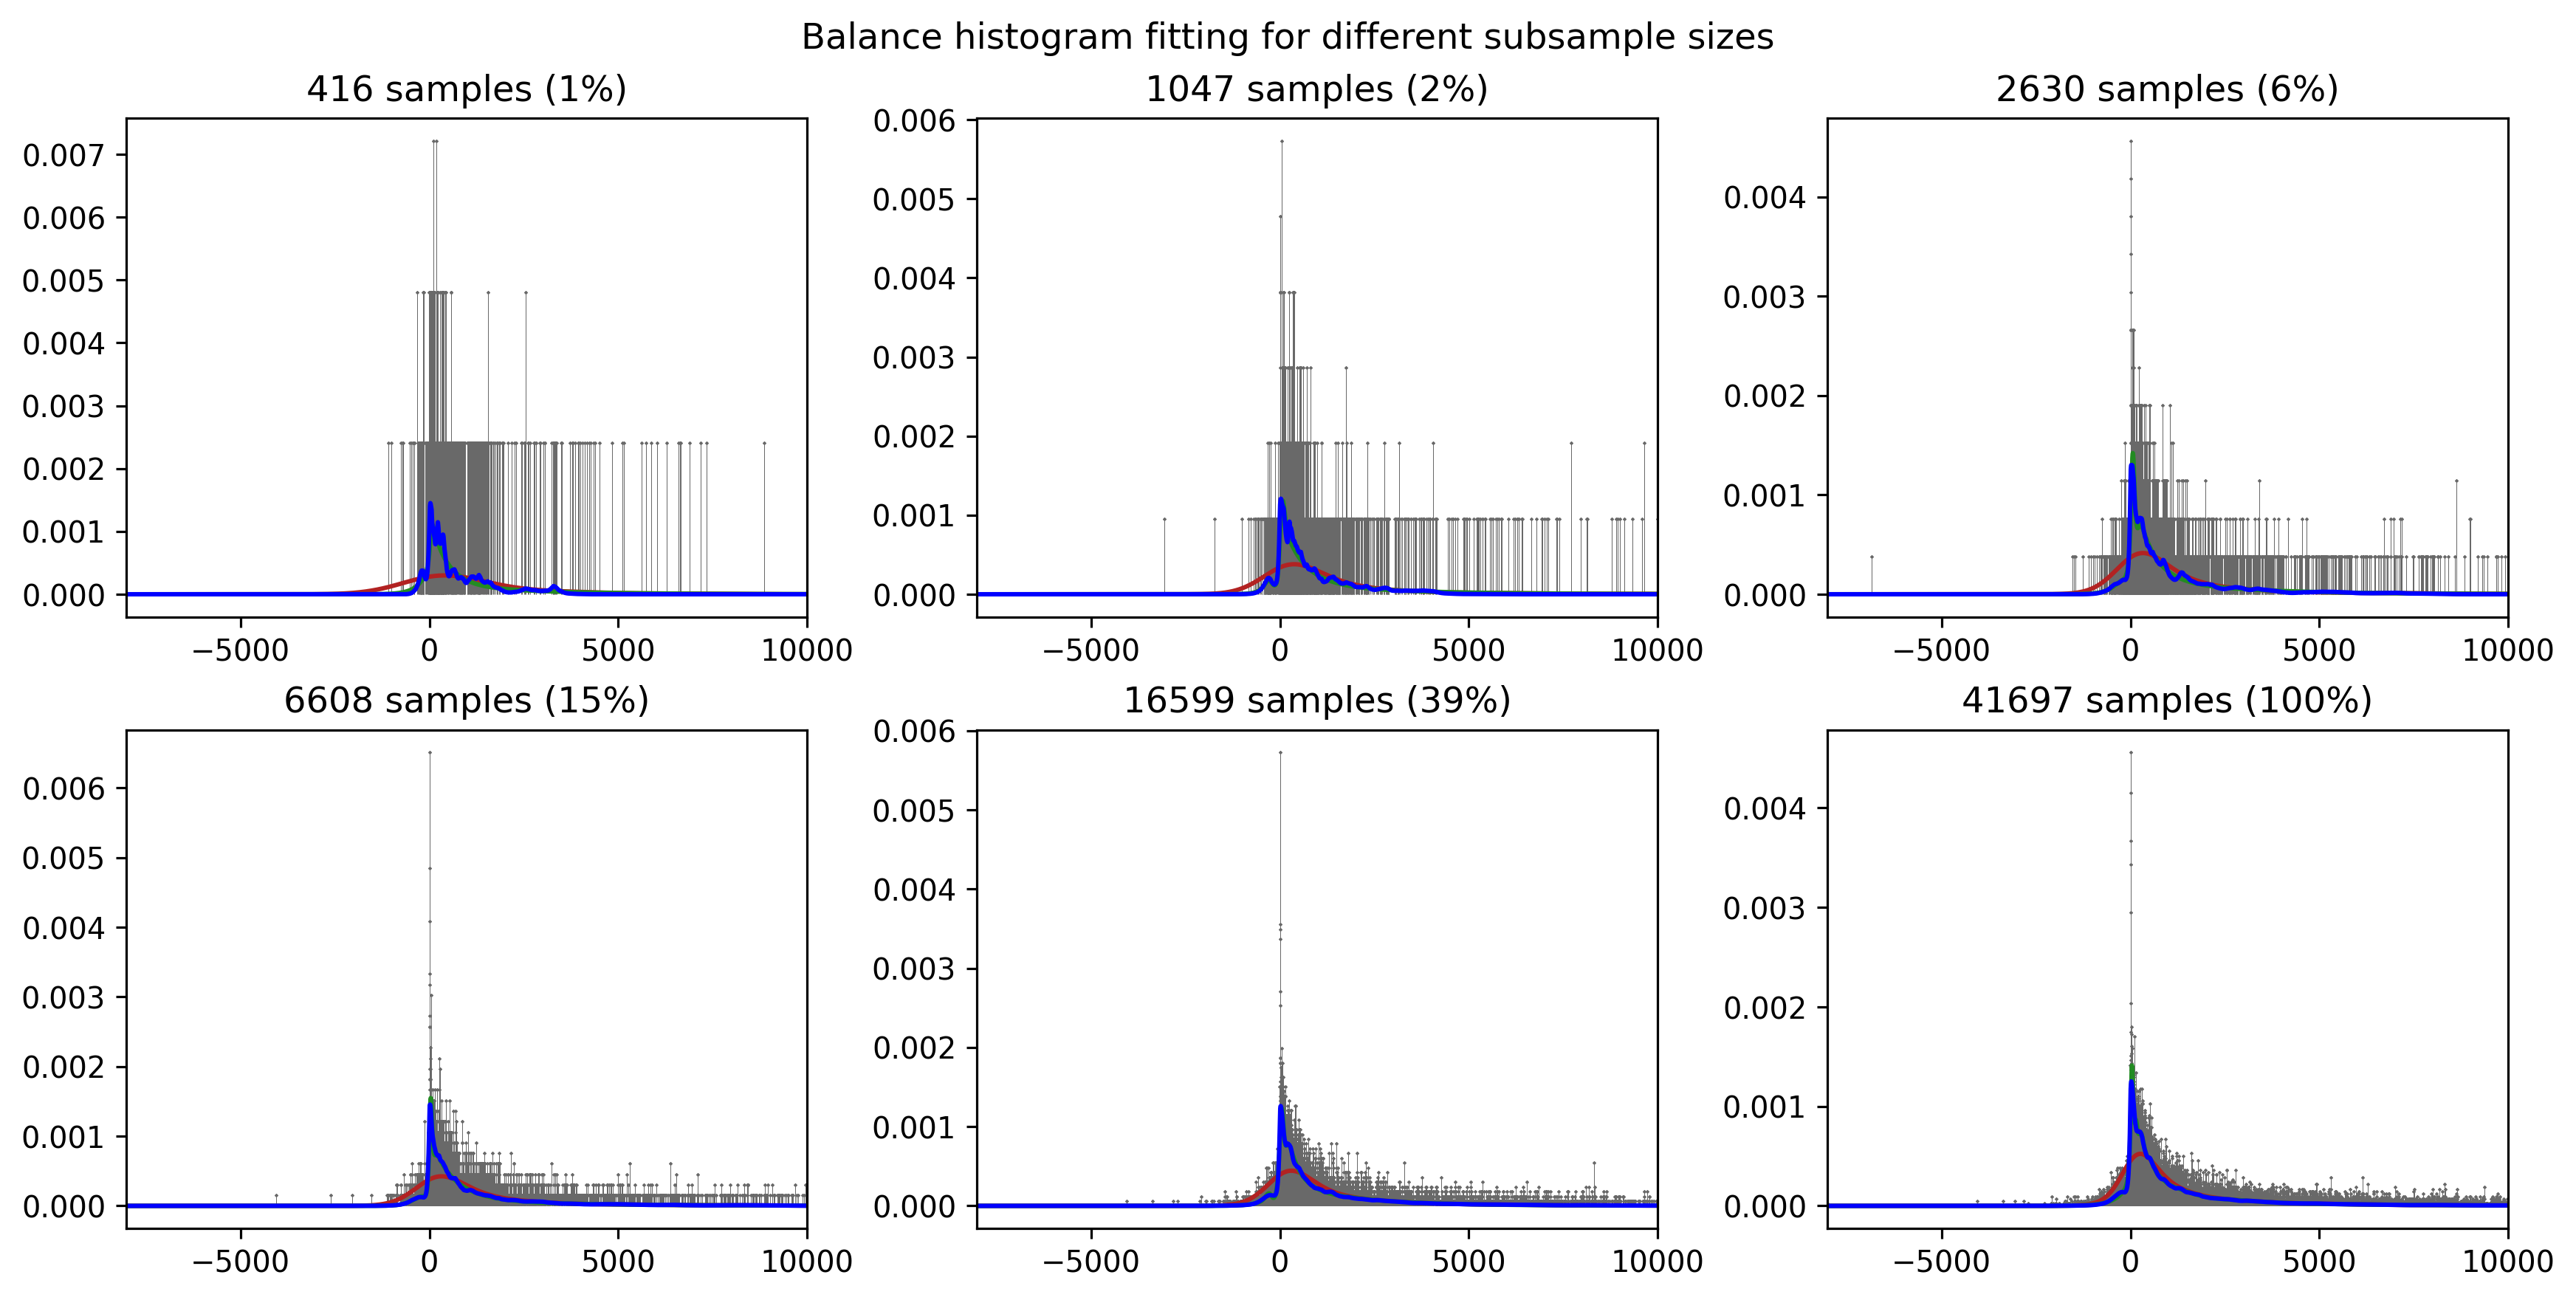

In [35]:
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), layout='constrained')
fig.suptitle(f'Balance histogram fitting for different subsample sizes')

for sz, pct, ax in zip(subsample_sizes, subsample_pct, axs.ravel(), strict=True):
    idx = np.random.choice(len(balance), sz)
    shifted_subsample = balance_shifted[idx]
    subsample = balance[idx]

    proj = laplacian_hist_estimator(shifted_subsample, max_val=max_val)
    kde_est = kde_curve(subsample, grid_x=xs)
    lspline_est = logspline_estimator(shifted_subsample.astype(float), max_val=max_val)

    empirical_hist = np.bincount(shifted_subsample, minlength=max_val)
    empirical_hist = empirical_hist.astype(float) / np.sum(empirical_hist)

    plot_empirical_hist(empirical_hist, ax, xs=xs)
    ax.plot(xs, kde_est, color=kde_color)
    ax.plot(xs, lspline_est, color=logspline_color)
    ax.plot(xs, proj, color=laplacian_color)
    ax.set_xlim([shift, 10000])
    ax.set_title(f'{sz} samples ({pct}%)')
plt.show()